In [1]:
import pandas as pd

In [2]:
crime_data = pd.read_csv('uk_street_crimes_data_2020_2023.csv')

---

## **Overview of the combined `crime_data` Dataset**


### Dataset Size

The dataset contains a total of **19,269,992** entries, making it a large comprehensive collection of crime data.

### Data Types

Here's a breakdown of the data types for each column:

- `Crime ID`: Object
- `Month`: Object (String representing a date)
- `Reported by`: Object 
- `Falls within`: Object 
- `Longitude`: Float64
- `Latitude`: Float64
- `Location`: Object
- `LSOA code`: Object
- `LSOA name`: Object 
- `Crime type`: Object 
- `Last outcome category`: Object 
- `Context`: Float64 (TO BE INSPECTED)

---


### Preview the dataframe to see columns

In [95]:
crime_data.sample()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
3280208,9fe2a7a3a8eb91cf89361af06ed4c0bf904e36420ed7bc...,2021-07,Devon & Cornwall Police,Devon & Cornwall Police,-3.510506,50.734802,On or near Prince Charles Road,E01020000,Exeter 002D,Criminal damage and arson,Investigation complete; no suspect identified,NaN


### See how much data is in the dataset

In [96]:
print(f'The length of the dataset is {len(crime_data):,}')

The length of the dataset is 19,269,992


### Check the types of each column

In [97]:
crime_data.dtypes

Crime ID                  object
Month                     object
Reported by               object
Falls within              object
Longitude                float64
Latitude                 float64
Location                  object
LSOA code                 object
LSOA name                 object
Crime type                object
Last outcome category     object
Context                  float64
dtype: object

---
# **Find the rate of missing values:**
### **Method:**
- `missing_values = data.isnull().sum()` is a great method to preview data and types.
-  To provide a more comprehensive view, calculating the percentage of missing values can offer deeper insights

### **Analysis : Finding patterns in columns with missing values**
- `Context` is missing 100% of values (it's also a float?) luckily it's probably not valuable to the analysis
- `Last outcome` category is important, it needs to be inspected further
- `Crime ID` may be a sensitve feature, or too granular for our analsis
---
- **Location Data:**
    - `LSOA Code` + `LSOA Name` missing 4%
    - `Longitiude` + `Latiude` missing 2%
    - This pattern suggests potential gaps in location data
---
- **`Last outcome category` missing data:**
   
    - **Anti-Social Behaviour Orders (ASBOs)**: ASBOs were civil orders issued in the UK to people who engaged in anti-social behavior.
     
        - However, ASBOs were replaced by the Anti-social Behaviour, Crime and Policing Act 2014 with new orders like the Criminal Behaviour Order (CBO) and the Community Protection Notice (CPN). 
        - If the dataset doesn't categorise these new orders as formal "outcomes," it might explain the missing data.
---        
### Method/Solution
- We will drop columns `Context` and `Crime ID`
- We'll add a `Last outcome category` 
    - if `Crime Type` = `Anti-Social Behavior` named: `No Formal Outcome`
    - We will later consider what is appropriate for the other missing Outcomes
---


In [98]:
def calculate_missing_statistics(df):
    # Calculate the number of missing values for each column
    missing_values_count = df.isnull().sum()

    # Calculate the percentage of missing values for each column
    missing_percentage = round((missing_values_count / len(df)) * 100, 0)

    # Create a DataFrame to display the results
    statistics_df = pd.DataFrame({
        'Column Name': missing_values_count.index,
        'Missing Count': missing_values_count.values,
        'Missing %': missing_percentage.values
    })

    # Filter out columns with no missing values and sort by percentage
    statistics_df = statistics_df[statistics_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)

    return statistics_df

calculate_missing_statistics(crime_data)

,Column Name,Missing Count,Missing %
11,Context,19269992,100.0
10,Last outcome category,4356540,23.0
0,Crime ID,4036619,21.0
7,LSOA code,821598,4.0
8,LSOA name,821598,4.0
4,Longitude,322599,2.0
5,Latitude,322599,2.0


In [99]:
def calculate_missing_statistics(df, group_column, missing_column):
    # Group and calculate missing values and total counts
    missing_counts = df[df[missing_column].isnull()].groupby(group_column).size()
    total_counts = df.groupby(group_column).size()

    # Ensure consistent indices and calculate missing percentages
    missing_counts = missing_counts.reindex(total_counts.index, fill_value=0)
    missing_percentages = (missing_counts / total_counts * 100).round(0)

    # Construct the result DataFrame
    statistics_df = pd.DataFrame({
        group_column: total_counts.index,
        f'Missing {missing_column} Count': missing_counts.values,
        'Missing %': missing_percentages.values
    }).sort_values(by='Missing %', ascending=False)

    return statistics_df

calculate_missing_statistics(crime_data, 'Crime type', 'Last outcome category')

,Crime type,Missing Last outcome category Count,Missing %
0,Anti-social behaviour,3886040,100.0
1,Bicycle theft,14925,7.0
11,Theft from the person,18065,7.0
4,Drugs,35164,6.0
3,Criminal damage and arson,67787,4.0
6,Other theft,48833,4.0
7,Possession of weapons,5681,4.0
5,Other crime,10359,3.0
9,Robbery,5025,3.0
10,Shoplifting,23688,3.0


### (Ireland and Wales will be considered for removal from the data)
##### This could become a focus on British Crime

In [100]:
calculate_missing_statistics(crime_data, 'Reported by', 'LSOA code').head(10)

,Reported by,Missing LSOA code Count,Missing %
32,Police Service of Northern Ireland,496959,100.0
14,Gloucestershire Constabulary,23266,11.0
5,City of London Police,1694,8.0
0,Avon and Somerset Constabulary,32197,6.0
21,Lancashire Constabulary,35704,6.0
2,British Transport Police,7923,5.0
3,Cambridgeshire Constabulary,9231,4.0
39,Thames Valley Police,27271,4.0
34,South Yorkshire Police,19723,4.0
9,Devon & Cornwall Police,13097,4.0


---        
### Method/Solution
- We will drop columns `Context` and `Crime ID`
- We'll add a `Last outcome category` if `Crime Type` = `Anti-Social Behavior` named: `No Formal Outcome`
---


In [101]:
data = crime_data.copy()


##### **Drop the unnessisary columns (Sensitive Features)**
- `Context` is missing 100% of values and is probably not valuable to the analysis
- `Crime ID` may be a sensitve feature, or too granular for our analsis


In [102]:
data = data.drop(columns=['Context', 'Crime ID'])


##### **Fill missing values for 'Anti-social behaviour' with `No Formal Outcome`**

In [103]:
# Fill missing values for 'Anti-social behaviour' with 'No Formal Outcome'
data.loc[data['Crime type'] == 'Anti-social behaviour', 'Last outcome category'] = data.loc[data['Crime type'] == 'Anti-social behaviour', 'Last outcome category'].fillna('No Formal Outcome')



##### **Validate the filled missing values of `Anti-Social Behavior`**


In [104]:
calculate_missing_statistics(data, 'Crime type', 'Last outcome category').head(3)


,Crime type,Missing Last outcome category Count,Missing %
1,Bicycle theft,14925,7.0
11,Theft from the person,18065,7.0
4,Drugs,35164,6.0


---
# **Exploratory Data Analysis (EDA):**
### **Method:**
- `calculate_statistics` is a great method to measure patterns and **distribution** of data.
- Use matplotlib to visualise the patterns and **distribution**
####  Distributions to inspect:
 - `Reported by` to see the frequency/distribution of crimes by police force
 - `Crime type` to see which crimes frequently occur
 - `Location` is there any frequent/generic locations?

---        

In [105]:
def calculate_statistics(df, column_name):
    counts = df[column_name].value_counts()
    percentages = ((counts / len(df)) * 100).round(2)

   

    return pd.DataFrame({

        column_name: counts.index,
        'count': counts.values,
        '%': percentages.values,

    }).sort_values(by='count', ascending=False)

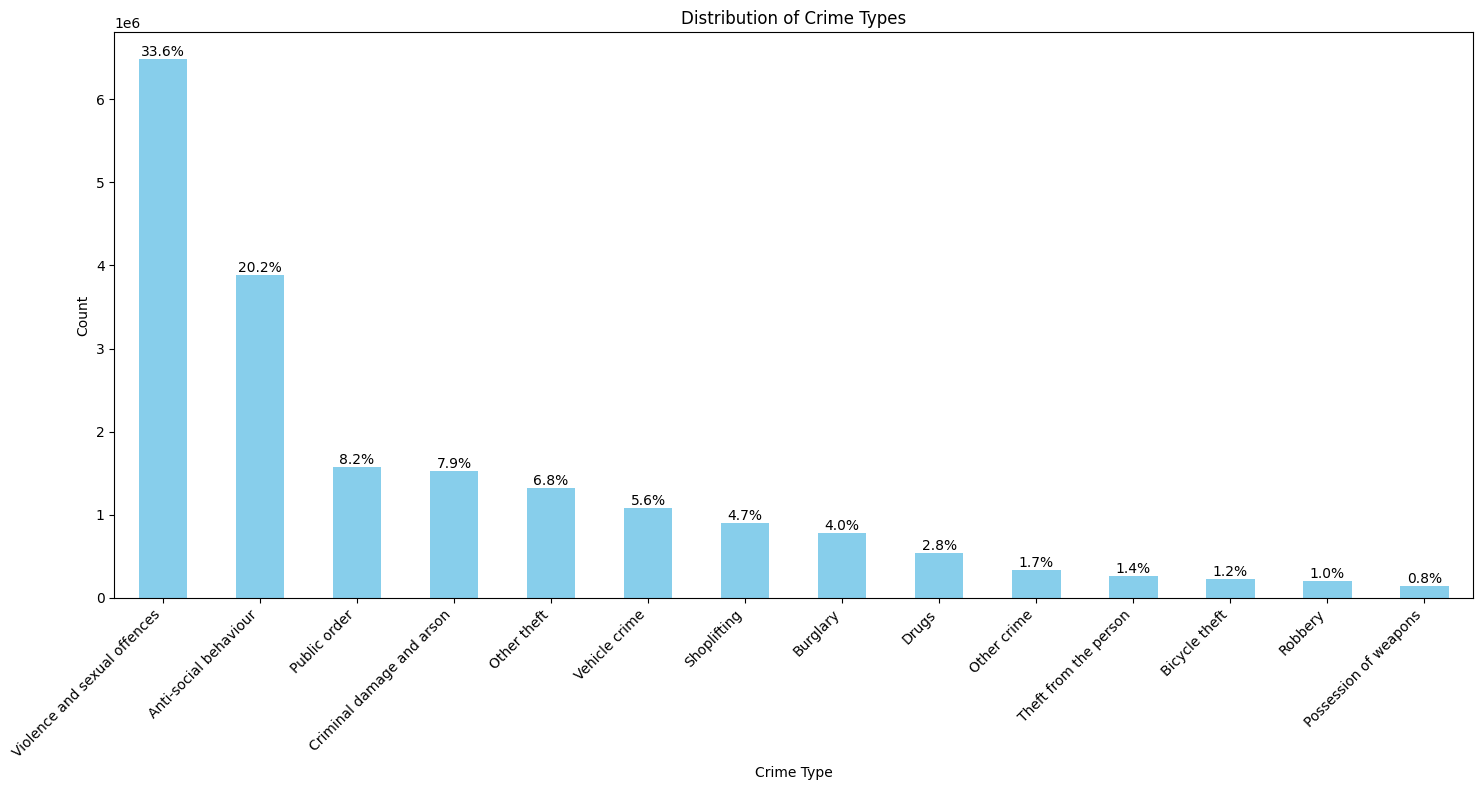

In [106]:
import matplotlib.pyplot as plt

# Get the count of each crime type
crime_counts = crime_data['Crime type'].value_counts()

# Calculate the percentage for each crime type
total_crimes = len(crime_data)
crime_percentage = (crime_counts / total_crimes) * 100

# matplotlib plotting paramaters
plt.figure(figsize=(15, 8))
bars = crime_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Annotate bars with the percentage values
for bar in bars.patches:
    yval = bar.get_height()
    bars.annotate(f'{yval/total_crimes:.1%}', 
                  (bar.get_x() + bar.get_width() / 2, yval),
                  ha='center', va='bottom', 
                  fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [107]:
calculate_statistics(crime_data, "Reported by")

,Reported by,count,%
0,Metropolitan Police Service,3423897,17.77
1,West Midlands Police,1161384,6.03
2,West Yorkshire Police,1028839,5.34
3,Thames Valley Police,643027,3.34
4,Kent Police,637375,3.31
5,Lancashire Constabulary,635765,3.30
6,Essex Police,599888,3.11
7,Northumbria Police,586400,3.04
8,Hampshire Constabulary,585785,3.04
9,Merseyside Police,562065,2.92


---        
### Method/Solution
- `Crime type` can easily be analyised, due to there only being 12 categories
- `Reported by` is harder to analyise, as there's **44 different police forces**
    - We will categorise all forces by region to better show distribution
    - This can also brings in an edge case 'Is larger distribution == higher population'
---


---
## **Categorisation of Police Forces by Geographical Regions**

- The police forces in the UK have been categorised based on the primary geographical regions they cover. This categorization helps in understanding the regional distribution and jurisdiction of each police force.
---

In [108]:
geographical_regions = {
    "South West England": [
        "Avon and Somerset Constabulary",
        "Devon & Cornwall Police",
        "Dorset Police",
        "Gloucestershire Constabulary",
        "Wiltshire Police"
    ],
    "South East England": [
        "Hampshire Constabulary",
        "Kent Police",
        "Surrey Police",
        "Sussex Police",
        "Thames Valley Police"
    ],
    "East of England": [
        "Bedfordshire Police",
        "Cambridgeshire Constabulary",
        "Essex Police",
        "Hertfordshire Constabulary",
        "Norfolk Constabulary",
        "Suffolk Constabulary"
    ],
    "London": [
        "Metropolitan Police Service",
        "City of London Police"
    ],
    "West Midlands": [
        "Staffordshire Police",
        "Warwickshire Police",
        "West Mercia Police",
        "West Midlands Police"
    ],
    "East Midlands": [
        "Derbyshire Constabulary",
        "Leicestershire Police",
        "Lincolnshire Police",
        "Northamptonshire Police",
        "Nottinghamshire Police"
    ],
    "North West England": [
        "Cheshire Constabulary",
        "Cumbria Constabulary",
        "Greater Manchester Police",
        "Lancashire Constabulary",
        "Merseyside Police"
    ],
    "North East England": [
        "Cleveland Police",
        "Durham Constabulary",
        "Northumbria Police",
        "North Yorkshire Police"
    ],
    "Yorkshire and the Humber": [
        "Humberside Police",
        "South Yorkshire Police",
        "West Yorkshire Police"
    ],
    "Wales": [
        "Dyfed-Powys Police",
        "Gwent Police",
        "North Wales Police",
        "South Wales Police"
    ],
    "Specialized/Other": [
        "British Transport Police",
        "Police Service of Northern Ireland"
    ]
}

# Feature engineering for Geographical Regions
def get_geographical_region(force_name):
    for region, forces in geographical_regions.items():
        if force_name in forces:
            return region
    return None

data['Geographical_Region'] = data['Reported by'].apply(get_geographical_region)

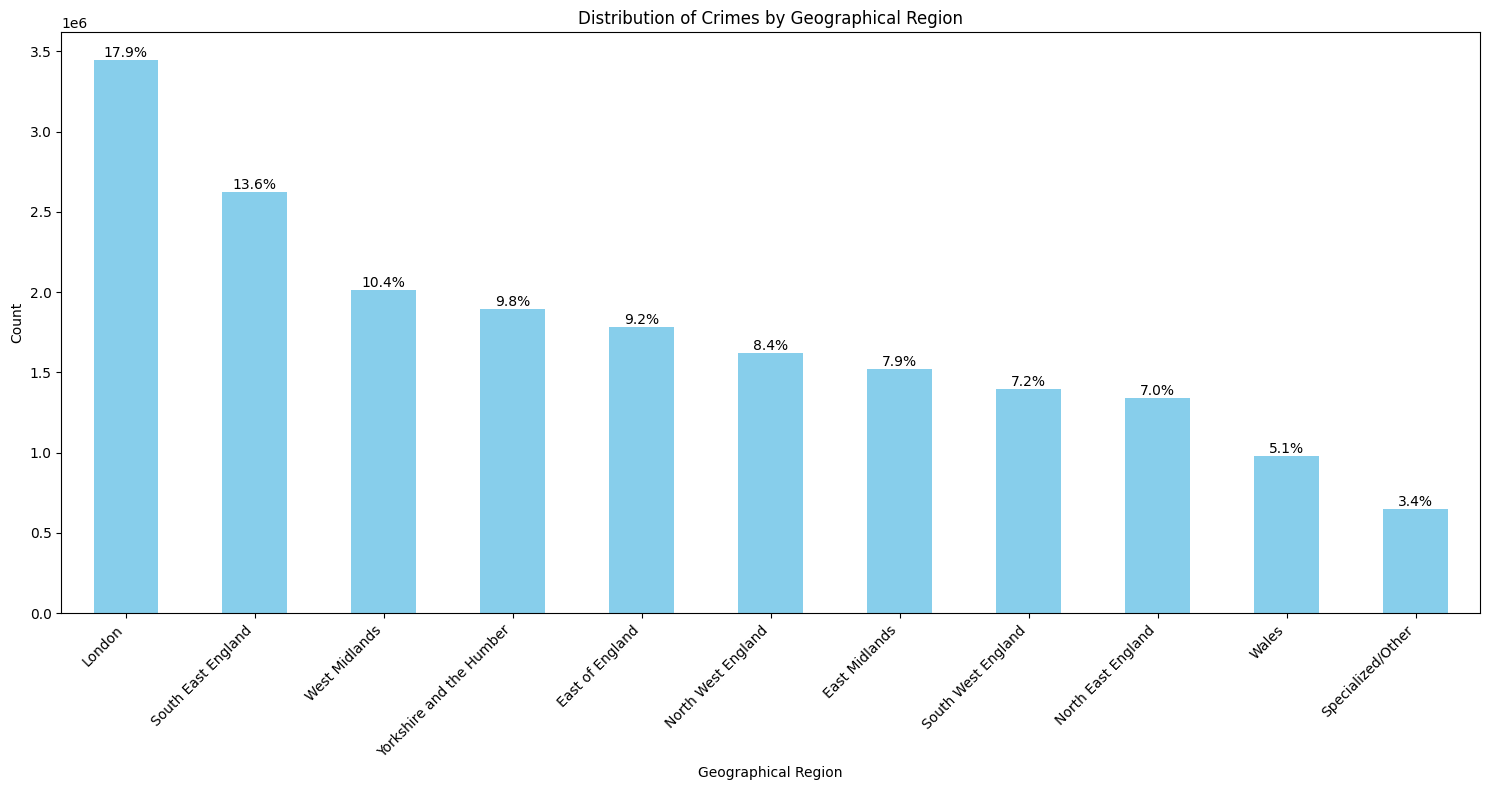

In [109]:
# Get the count of crimes by geographical region
region_counts = data['Geographical_Region'].value_counts()

# Calculate the percentage for each region
total_crimes = len(crime_data)
region_percentage = (region_counts / total_crimes) * 100

# matplotlib plotting parameters
plt.figure(figsize=(15, 8))
bars = region_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Crimes by Geographical Region')
plt.xlabel('Geographical Region')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Annotate bars with the percentage values
for bar in bars.patches:
    yval = bar.get_height()
    bars.annotate(f'{yval/total_crimes:.1%}', 
                  (bar.get_x() + bar.get_width() / 2, yval),
                  ha='center', va='bottom', 
                  fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [110]:
# Filter by generic locations
frequent_generic_locations = [
    "On or near Supermarket",
    "On or near Parking Area",
    "On or near Shopping Area",
    "On or near Sports/Recreation Area",
    "On or near Petrol Station",
    "On or near Pedestrian Subway",
    "On or near Nightclub",
    "On or near High Street",
    "On or near Theatre/Concert Hall",
    "On or near Conference/Exhibition Centre",
    "On or near Hospital",
    "On or near Prison",
    "On or near Park/Open Space",
    "On or near Police Station",
    "On or near Further/Higher Educational Building"
]

generic_locations_data = data[data['Location'].isin(frequent_generic_locations)]
print(f"Number of crimes at generic locations: {len(generic_locations_data): ,.0f}")

Number of crimes at generic locations:  2,262,524


Number of crimes at generic locations:  2,262,524


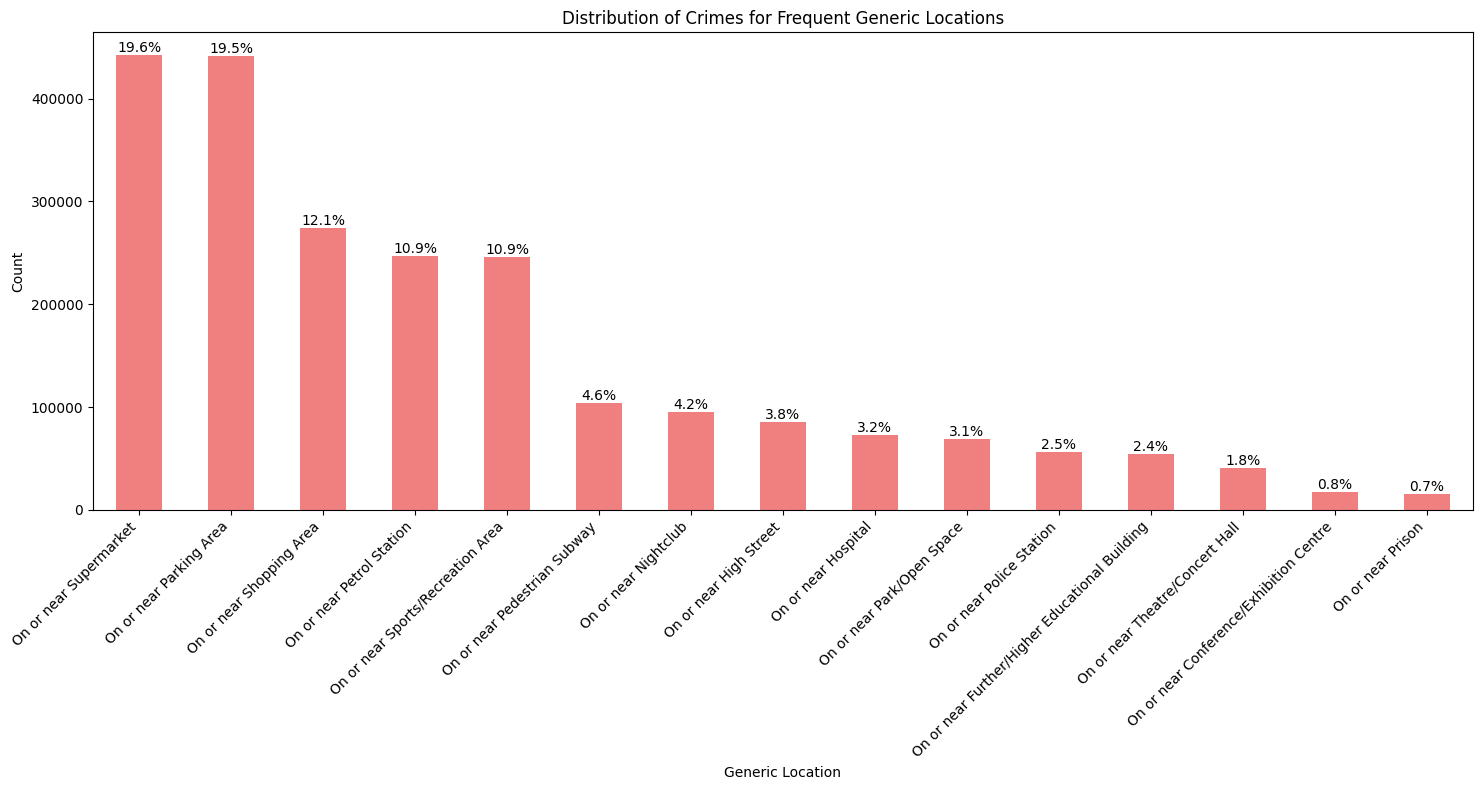

In [111]:
# Filter the data for the frequent generic locations
generic_locations_data = data[data['Location'].isin(frequent_generic_locations)]
print(f"Number of crimes at generic locations: {len(generic_locations_data): ,.0f}")

# Get the count of crimes for these generic locations
location_counts = generic_locations_data['Location'].value_counts()

# Calculate the percentage for each location
total_crimes_generic = len(generic_locations_data)
location_percentage = (location_counts / total_crimes_generic) * 100

# matplotlib plotting parameters
plt.figure(figsize=(15, 8))
bars_generic = location_counts.plot(kind='bar', color='lightcoral')
plt.title('Distribution of Crimes for Frequent Generic Locations')
plt.xlabel('Generic Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Annotate bars with the percentage values
for bar in bars_generic.patches:
    yval = bar.get_height()
    bars_generic.annotate(f'{yval/total_crimes_generic:.1%}', 
                          (bar.get_x() + bar.get_width() / 2, yval),
                          ha='center', va='bottom', 
                          fontsize=10, color='black')

plt.tight_layout()
plt.show()


### **Generic Location Analysis:**
#####  - **Supermarkets and Parking areas**
- These two locations top the list with almost identical counts, accounting for almost 40% of the crimes committed in the generic locations. This suggests that they are a hotspot for criminal activity

##### - **Shopping Areas and Petrol Stations**
- These are also significant areas for concern, with **Shopping Areas** accounting for over 12% and **Petrol Stations** for almost 11% of the crimes
- **Shopping areas**, like **Supermarkets** are common locations where many people gather, making them targets for various crimes. **Petrol Stations** are genrally open late at night, sometimes with minimal staff and could be vunerable to theft and other crimes

##### - **Sports/Recreation Areas:**
- Almost 11% of the crimes occur in these areas
- Given that **Sports/Recreation Areas** are places for leasure and enjoyment, this is concerning...
- It could be related to disputes, thefts from facilities or  issues from gatherings at events
- This defintion needs to be inspected further using the `logitude` and `latitude`, then we could see which are the most frequent areas of this location type to better define it.


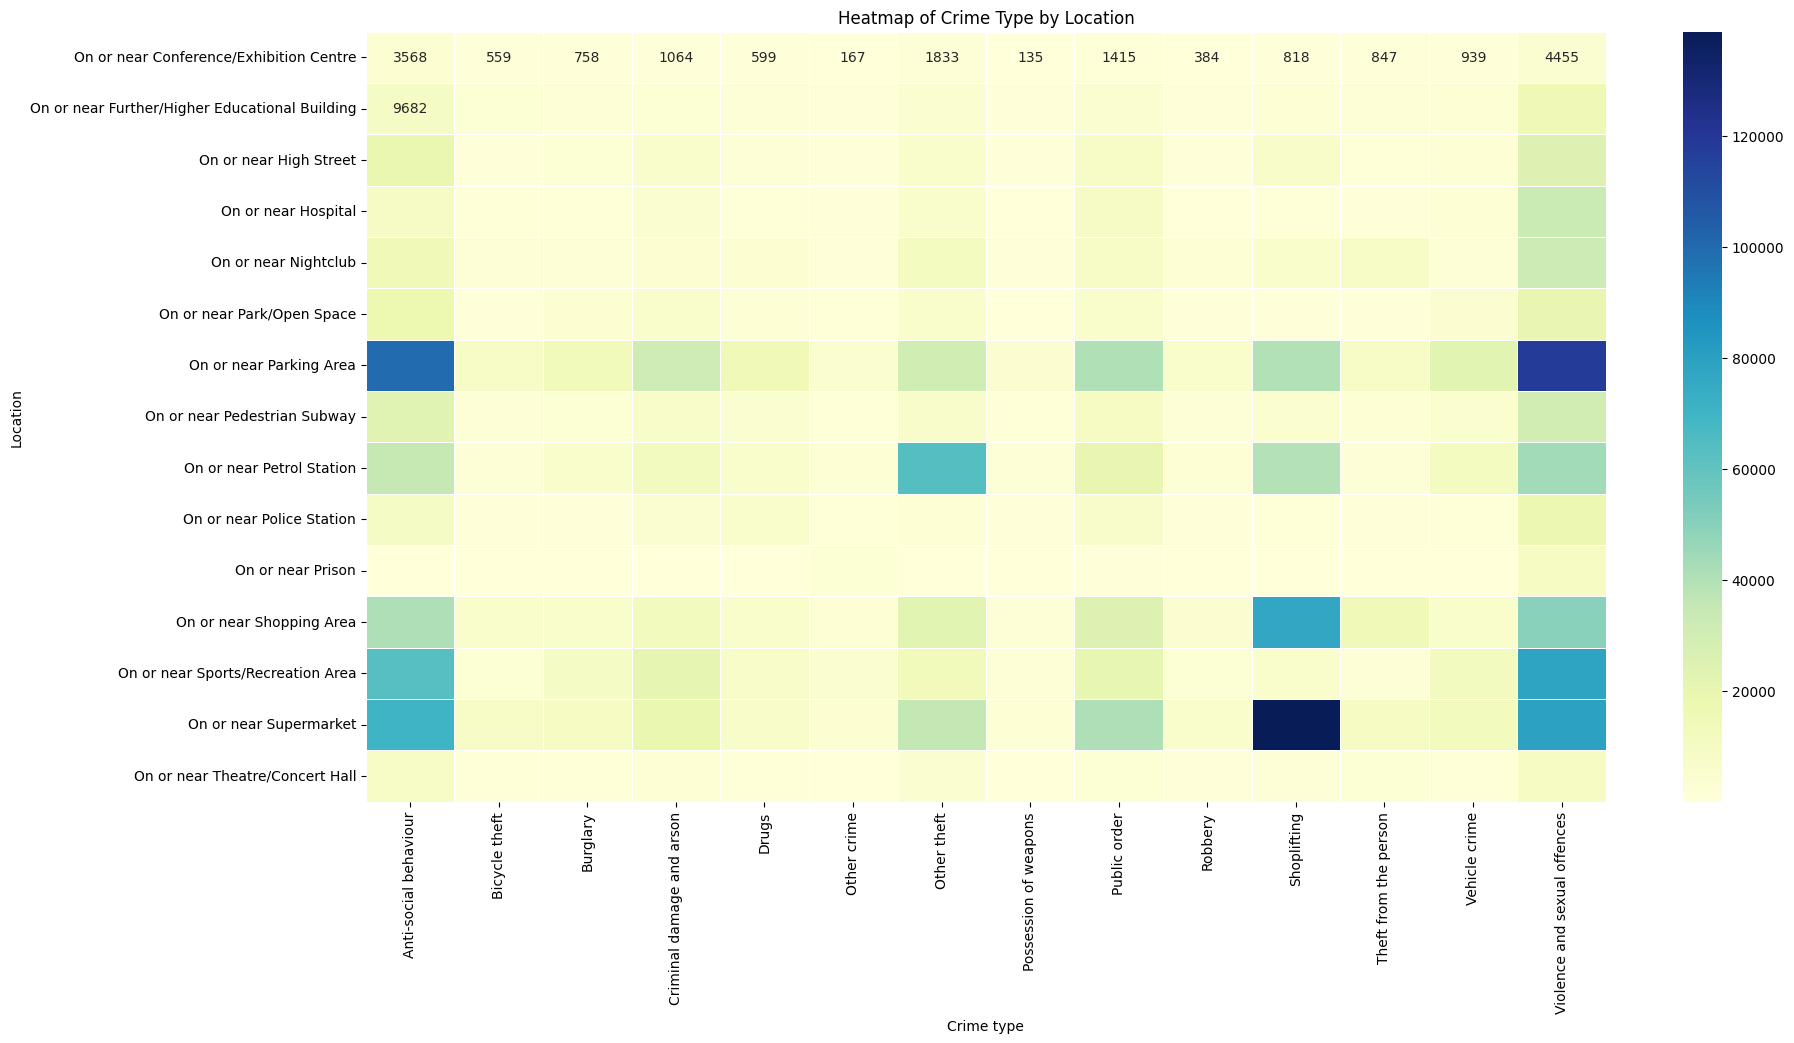

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already loaded your data into the 'data' DataFrame

# Filter the data for the frequent generic locations
generic_locations_data = data[data['Location'].isin(frequent_generic_locations)]

# Create a pivot table with Location as rows, Crime type as columns, and count of occurrences as values
pivot_table = pd.pivot_table(generic_locations_data, values='Month', index='Location', columns='Crime type', aggfunc='count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Heatmap of Crime Type by Location')
plt.show()


### **Generic Location Crime Types Analysis**
##### **Anti-social Behaviour:**
- This type of crime is most prevalent `Parking Area`, followed by `Supermarket` and `Sports/Recreation Area`.

##### **Shoplifting:**
 - As expected, `Supermarket` has the highest count of shoplifting incidents, significantly more than any other location. `Shopping Area` is the second most common place for shoplifting.

##### **Bicycle Theft:**
- `Supermarket` and `Parking Area` are the most common places for bicycle thefts, but the numbers are relatively low compared to other crimes.

##### **Other Theft:**
- `Petrol Station` has a surprisingly high count of other thefts, even more than `Supermarket` or `Parking Area`.

##### **Violence and Sexual Offences:**
- `Parking Area` has the highest count for violence and sexual offences, this is an alarming insight. This  then is followed by `Sports/Recreation Area` and `Supermarket`, which have simular counts.